# Introducción
El proceso que he seguido para separar letras a partir de las que genero un dataset.

Este proceso está automatizado en el script `src/<nombre_script>.py`.

In [31]:
import re
import os
import cv2
from matplotlib import pyplot as plt
import pytesseract
import datetime as dt

#import numpy as np
#
#
#from pytesseract import Output
#
#from PIL import Image

print("Setup completado!")

Setup completado!


In [32]:
def get_image(file_path):
    return cv2.imread(file_path)

def get_captcha_text_from_filename(file_path):
    filename = os.path.basename(file_path)
    return re.sub("\.png$", "", filename)

def show(image):
    plt.imshow(image, cmap='Greys')
    plt.show()

def image_to_bnw(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def smoothing_median_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.medianBlur(image.copy(), i)
    return smoothed_image

def image_thresholding(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,91,2)

def get_contours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_area(width, height):
    return width * height

def get_regions(contours):
    regions = []
    
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # Asumo que si el área de un rectángulo es menor de 500px² se trata de una agrupación de puntos en vez de una letra
        if get_area(w, h) > 500:
            regions.append((x, y, w, h))

    return regions

def get_sorted_regions_by_area_size(regions):
    '''
    recibe:   Una lista con regiones.
              Cada región es una tupla con cuatro valores:
              - coordenada x
              - coordenada y
              - altura
              - anchura
    devuelve: la lista ordenada de región con mayor área a región con menor área 
    '''
    # Los índices 2 y 3 corresponden a altura y anchura
    return sorted(regions, key=lambda x: get_area(x[2], x[3]), reverse = True)

def get_largest_region_by_area_size(regions):
    return get_sorted_regions_by_area_size(regions)[0]

def divide_region_by_width(region):
    '''
    recibe: una tupla con cuatro valores:
            - coordenada x
            - coordenada y
            - anchura
            - altura

    devuelve: dos regiones resultado de la división de la región anterior por anchura.
    '''
    x, y, w, h = region
    half_width = w // 2
    
    result = []
    result.append((x, y, half_width, h))
    result.append((x + half_width, y, half_width, h))
    
    return result

def paint_regions(image, regions):
    for region in regions:
        x, y, w, h = region
        cv2.rectangle(image, (x,y), (x+w,y+h), (255,0,0),1)
    plt.imshow(image)

def get_sorted_regions_by_coord_x(regions):
    return sorted(regions, key=lambda r: r[0])

def save_letter_image(image, letter, output_folder = 'input/letter_dataset/training/'):
    save_path = os.path.join(output_folder, letter)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    filename = letter + "_" + dt.datetime.now().strftime("%y%m%d_%H%M%S%fZ")

    file_path = os.path.join(save_path, f"{filename}.png")
    cv2.imwrite(file_path, image)


## Cargo la imagen del captcha

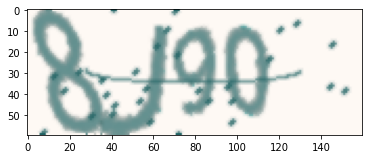

El texto que oculta es:  8J90


In [33]:
#captcha_image_filename = 'input/captchas_dataset/train_data/1BCS.png'
#captcha_image_filename = 'input/captchas_dataset/train_data/DXOJ.png'
#captcha_image_filename = 'input/captchas_dataset/train_data/EZHQ.png'
captcha_image_filename = 'input/captchas_dataset/train_data/8J90.png'

image = get_image(captcha_image_filename)

show(image)
print("El texto que oculta es: ", get_captcha_text_from_filename(captcha_image_filename))

## Pasar la imagen a Blanco y Negro

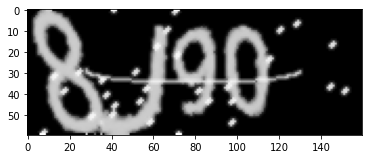

In [34]:
image_bnw = image_to_bnw(image.copy())

show(image_bnw)

## Smoothing
Quitamos el ruido del captcha para aislar los caracteres lo mejor posible.

Pruebo varios métodos para ver con cual obtengo mejores resultados:

### Homogeneous Blur

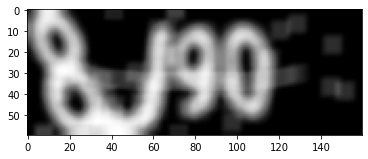

In [35]:
def smoothing_homogeneous_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.blur(image.copy(), (i, i))
    return smoothed_image
        
smoothed_image = smoothing_homogeneous_blur(image_bnw)
show(smoothed_image)

### Gaussian Blur

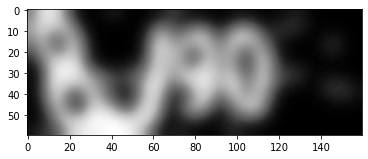

In [36]:
def smoothing_gaussian_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.GaussianBlur(image.copy(), (i, i), 0)
    return smoothed_image
        
smoothed_image = smoothing_gaussian_blur(image_bnw, max_kernel_length = 31)
show(smoothed_image)

### Bilateral Filter

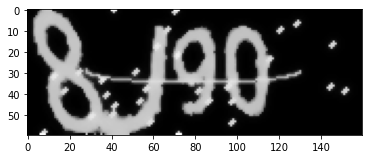

In [37]:
def smoothing_bilateral_filter(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.bilateralFilter(image.copy(), i, i * 2, i / 2)
    return smoothed_image
        
smoothed_image = smoothing_bilateral_filter(image_bnw)
show(smoothed_image)

### Median Blur

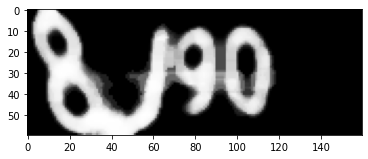

In [38]:
def smoothing_median_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.medianBlur(image.copy(), i)
    return smoothed_image
        
smoothed_image = smoothing_median_blur(image_bnw)
show(smoothed_image)

### Conclusión
Después de aplicar los cuatro métodos me quedo con **Median Blur**. 

**Nota** ¿Se puede aplicar primero un método, después otro, etc. para obtener mejor resultado?

## Adaptative Thresholding
Tras haber hecho un *smoothing* de la imagen le pasamos un adaptative thresholding para definir los caracteres. 

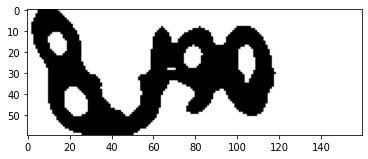

In [39]:
thresholded_image = image_thresholding(smoothed_image)

show(thresholded_image)

# Probando el OCR Tesseract
Pruebo cómo distingue este OCR las imágenes.

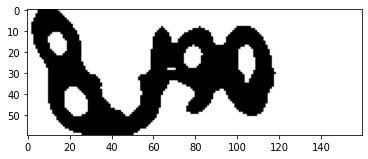

Resultado:  


In [40]:
# Las opciones que he usado para Tesseract
# - psm 11 (page segmentation modes). Selecciono 11: trata la imagen como si fuese una única línea de texto. 
# - oem 1 (OCR engine mode). Selecciono 1: Neural nets LSTM engine only.
# - tessedit_char_whitelist: ignora los caracteres que no estén en esta lista.

custom_config = '--psm 11 --oem 1 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
ocr_result = pytesseract.image_to_string(thresholded_image, config=custom_config)

show(thresholded_image)

print("Resultado: ", ocr_result)

## Conclusión
Parece que el OCR no funciona muy bien.

# Buscamos la región de cada letra
**importante** cuando tenga todas las letras tengo que comprobar si el set de datos está balanceado (si hay más o menos el mismo número de cada letra).

## Encuentro el contorno de las letras

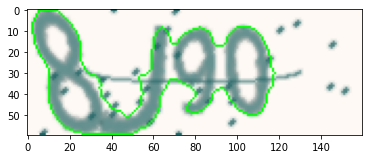

In [41]:
contours = get_contours(thresholded_image)

# Código de test
test_image = image.copy()
cv2.drawContours(test_image, contours, -1, (0,255,0), 1)
show(test_image)


## Busco la región de cada letra
Una región es el rectángulo que envuelve cada letra.

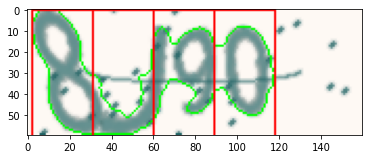

In [42]:
# Una región es el rectángulo que envuelve cada letra
regions = get_regions(contours)

# Estamos tratando captchas de 4 letras.
# Si recibimos menos de 4 regiones seguramente se han juntado varias letras en una sola región que hay que dividir.
while len(regions) < 4:
    largest_region = get_largest_region_by_area_size(regions)
    new_regions = divide_region_by_width(largest_region)
    regions += new_regions
    regions.remove(largest_region)

# Muestro las regiones sobre la imagen:
paint_regions(test_image, regions)

# El último paso es guardar una imagen de cada región
Cada región representa una letra o número se guardará en un directorio diferente:
- `input/letter_dataset/training/a/` para todas las letras "a"
- `input/letter_dataset/training/b/` para todas las letras "b"
- `input/letter_dataset/training/c/` para todas las letras "c"
- etc.

Esos directorios son los que forman el conjunto de datos de entrenamiento para los algoritmos de machine learning.

In [43]:
for region, letter in zip(get_sorted_regions_by_coord_x(regions), get_captcha_text_from_filename(captcha_image_filename)):
    x, y, w, h = region
    
    letter_image = image_bnw[y:y + h, x:x + w]
    save_letter_image(letter_image, letter)

    print(f"Imagen para la letra {letter} guardada.")

Imagen para la letra 8 guardada.
Imagen para la letra J guardada.
Imagen para la letra 9 guardada.
Imagen para la letra 0 guardada.
